---

In [25]:
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import locale
import os
import os.path as osp
from typing import List, Dict, Set, Callable
from mpl_toolkits.axes_grid1 import make_axes_locatable


HOME = "../../"
DATA = osp.join(HOME, "data")
CODE = osp.join(HOME, "code")
GREENSPACE_DATA = osp.join(DATA, "greenspace_data")
CENSUS_DATA = osp.join(DATA, "census_code_mappers")
STATES = geopandas.read_file('./state_shape_data/usa-states-census-2014.shp')
STATES.crs
STATES = STATES.to_crs("EPSG:3395")

CLEAN_DATA = osp.join(HOME, "clean_data")
CLEAN_GREENSPACE_DATA = osp.join(CLEAN_DATA, "greenspace_data")

In [26]:
def plot_on_US_map(
    fnc: Callable[[pd.Series], int], 
    col_name: str
):

    fig, ax = plt.subplots(1, 1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    STATES[col_name] = STATES.apply(fnc, axis = 1)
    STATES.plot(column = col_name, ax=ax, legend = True, cax=cax)
    plt.title("How "+str(col_name)+" varies by state")
    plt.show()

Getting all the locational dataframes

In [27]:
city_df = pd.read_csv(osp.join(CENSUS_DATA, "us_city_info.csv"))
blocks_df = pd.read_csv(osp.join(CENSUS_DATA, "us_blocks.csv"))
fips_df = pd.read_csv(osp.join(CENSUS_DATA, "fips_codes.csv"))

# Getting some dictionaries from the blocks_df
dc_block_geo_id_state_fip = dict(zip(blocks_df.block_geoid, blocks_df.state_fip))
dc_block_geo_id_county_fip = dict(zip(blocks_df.block_geoid, blocks_df.county_fip))
dc_block_geo_id_county_name = dict(zip(blocks_df.block_geoid, blocks_df.county_name))

# Getting dictionaries from the fips_df
dc_state_fip_to_state_abb = dict(zip(fips_df.state_code, fips_df.state))

# Getting dictionaries from the city_df
dc_county_fips_to_state_name =  dict(zip(city_df.county_fips, city_df.state_abbr))
dc_city_name_to_state_name =  dict(zip(city_df.city, city_df.state_abbr))

# blocks_df.sample(10)

In [28]:
tree_df = pd.read_csv(osp.join(GREENSPACE_DATA, "5_million_trees_us_cities_cleaned.csv"))
pcc = pd.read_csv(osp.join(CLEAN_GREENSPACE_DATA, "percent_cover_county.txt"))
urban_tree_canopy_df = pd.read_csv(osp.join(CLEAN_GREENSPACE_DATA,"urban_tree_canopy.csv"))

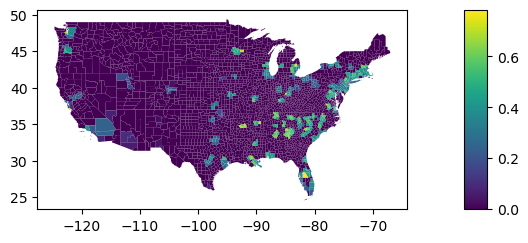

In [32]:
import geopandas as gpd
import pandas as pd

urban_tree_canopy_df['fip'] = urban_tree_canopy_df['state_fip']*1000 +  urban_tree_canopy_df['county_fip']

covid_df = pd.read_csv('us_counties_covid19_daily.csv')
dc = urban_tree_canopy_df.groupby(['fip']).mean()['mean_percent_tree_cover'].to_dict()

# Load the json file with county coordinates
geoData = gpd.read_file(
    'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson'
)

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)
geoData = geoData.rename(columns={'id': 'fips_id'})

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

def app(row):
    if(row.fips_id in dc):
        return dc[row.fips_id]
    else:
        return 0

geoData['covid_cases'] = geoData.apply(
    lambda row: app(row),
    axis = 1,
)
geoData.plot(column = 'covid_cases', ax=ax, legend = True, cax=cax)
plt.show()

In [34]:
urban_tree_canopy_df.groupby(['fip']).mean()['mean_percent_tree_cover']


fip
1003.0     0.394907
1009.0     0.636328
1073.0     0.573932
1083.0     0.465047
1089.0     0.501788
             ...   
55089.0    0.451647
55101.0    0.516774
55109.0    0.706463
55131.0    0.507955
55133.0    0.479116
Name: mean_percent_tree_cover, Length: 478, dtype: float64

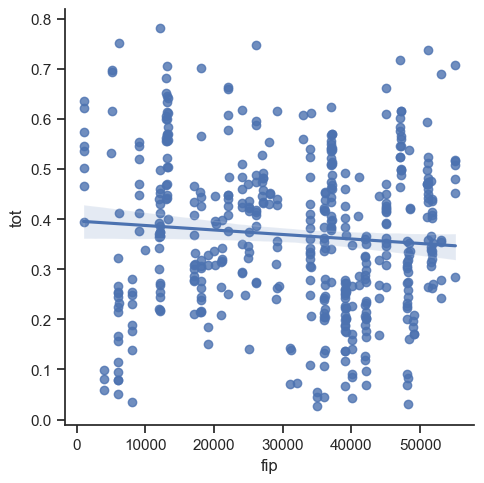

In [41]:
import seaborn as sns
sns.set_theme(style="ticks")


# Show the results of a linear regression within each dataset
sns.lmplot(
    data = urban_tree_canopy_df.groupby(['fip']).mean()['mean_percent_tree_cover'].reset_index(name ='tot'),
    x="fip", y="tot"
)

In [38]:
urban_tree_canopy_df.groupby(['fip']).mean()['mean_percent_tree_cover'].reset_index(name ='Total Amount')

,fip,Total Amount
0,1003.0,0.394907
1,1009.0,0.636328
2,1073.0,0.573932
3,1083.0,0.465047
4,1089.0,0.501788
...,...,...
473,55089.0,0.451647
474,55101.0,0.516774
475,55109.0,0.706463
476,55131.0,0.507955


478


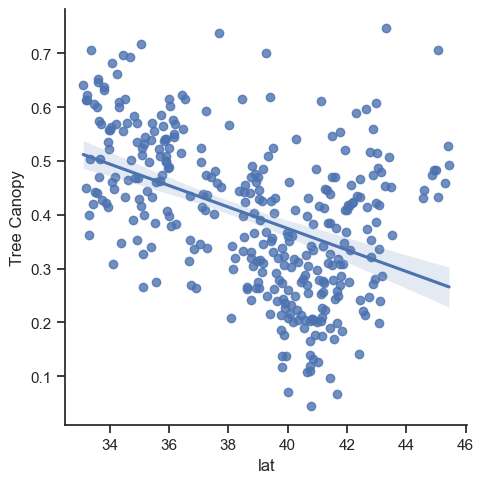

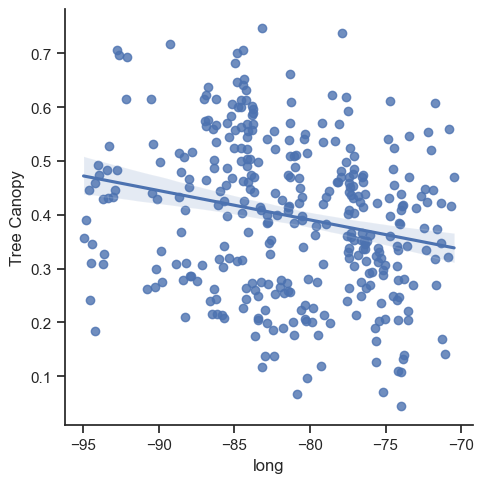

In [60]:
ndf = urban_tree_canopy_df.groupby(['fip']).mean()['mean_percent_tree_cover'].reset_index(name ='Tree Canopy')
dc_county_fips_to_lat =  dict(zip(city_df.county_fips, city_df.latitude_centroid))
dc_county_fips_to_long =  dict(zip(city_df.county_fips, city_df.longitude_centroid))
ndf['lat'] = ndf['fip'].map(dc_county_fips_to_lat)
ndf['long'] = ndf['fip'].map(dc_county_fips_to_long)
print(len(ndf))
ndf = ndf[ndf['long'] > -95]
ndf = ndf[ndf['lat'] > 33]


sns.lmplot(
    data = ndf,
    x="lat", y="Tree Canopy"
)

sns.lmplot(
    data = ndf,
    x="long", y="Tree Canopy"
)



In [52]:
len(ndf)

361